In [1]:
# # A fit with BAT.jl
#
# In this example we show how to bring the PDF parametrisation and
# forward model together with `BAT.jl` to perform a fit of simulated data.
# This fit is a work in progress and just a starting point for verification
# of the method.

In [2]:
using BAT, DensityInterface
using PartonDensity
using QCDNUM
using Plots, Random, Distributions, ValueShapes, ParallelProcessingTools
using StatsBase, LinearAlgebra
using SpecialFunctions, Printf
using Distributions
import HDF5
using DelimitedFiles
using LaTeXStrings
using HypothesisTests


Plots.gr(format="png")

Plots.GRBackend()

In [4]:
samples_data = bat_read("/Users/AllenCCaldwell/F2/Dirichlet-DataFit/Data-Dirichlet-sysrun-priors-tight.h5").result
samples_sim = bat_read("/Users/AllenCCaldwell/F2/Dirichlet-referencefit/results-Dirichlet-ref.h5").result

DensitySampleVector, StructArray with 5 columns and 40914 rows:
      v                       logd      weight  info                    aux
    ┌──────────────────────────────────────────────────────────────────────────
 1  │ (θ = [0.334157, 0.074…  -1170.87  6       MCMCSampleID(9, 12, 0…  nothing
 2  │ (θ = [0.336139, 0.067…  -1171.43  1       MCMCSampleID(9, 12, 6…  nothing
 3  │ (θ = [0.338236, 0.063…  -1170.98  17      MCMCSampleID(9, 12, 7…  nothing
 4  │ (θ = [0.335593, 0.063…  -1169.38  8       MCMCSampleID(9, 12, 2…  nothing
 5  │ (θ = [0.335158, 0.057…  -1166.93  4       MCMCSampleID(9, 12, 3…  nothing
 6  │ (θ = [0.338377, 0.045…  -1164.13  6       MCMCSampleID(9, 12, 3…  nothing
 7  │ (θ = [0.337713, 0.044…  -1162.53  3       MCMCSampleID(9, 12, 4…  nothing
 8  │ (θ = [0.340799, 0.034…  -1163.81  9       MCMCSampleID(9, 12, 4…  nothing
 9  │ (θ = [0.340813, 0.034…  -1158.96  3       MCMCSampleID(9, 12, 5…  nothing
 10 │ (θ = [0.338671, 0.044…  -1159.84  2       MCMCSampleID

In [5]:
pdf_params_gen, sim_data = pd_read_sim("/Users/AllenCCaldwell/F2/Dirichlet-referencefit/simulation-Dirichlet.h5")

(DirichletPDFParams
  param_type: Int64 2
  seed: Int64 0
  weights: Array{Float64}((9,)) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  θ: Array{Float64}((9,)) [0.332, 0.111, 0.288, 0.109, 0.117, 0.023, 0.0066, 0.0066, 0.0066]
  K_u: Float64 3.71
  λ_u: Float64 0.9374820143884892
  K_d: Float64 4.03
  λ_d: Float64 0.6280427446569179
  λ_g1: Float64 1.79
  λ_g2: Float64 -0.21
  K_g: Float64 4.7
  λ_q: Float64 -0.33
, Dict{String, Any}("counts_obs_em" => UInt64[0x00000000000002f8, 0x000000000000023a, 0x00000000000001c1, 0x00000000000001f0, 0x000000000000018a, 0x0000000000000161, 0x0000000000000125, 0x000000000000037b, 0x000000000000030e, 0x00000000000002d8  …  0x0000000000000033, 0x0000000000000039, 0x0000000000000024, 0x0000000000000014, 0x000000000000000d, 0x0000000000000008, 0x0000000000000006, 0x0000000000000000, 0x00000000000000ac, 0x000000000000000c], "counts_obs_ep" => UInt64[0x000000000000023d, 0x00000000000001ce, 0x0000000000000184, 0x0000000000000187, 0x0000000000000119, 0x00

In [6]:
qcdnum_grid = QCDNUMGrid(x_min=[1.0e-3, 1.0e-1, 5.0e-1], x_weights=[1, 2, 2], nx=100,
                         qq_bounds=[1.0e2, 3.0e4], qq_weights=[1.0, 1.0], nq=50, spline_interp=3)
qcdnum_params = QCDNUMParameters(order=2, α_S=0.118, q0=100.0, grid=qcdnum_grid,
                                 n_fixed_flav=5, iqc=1, iqb=1, iqt=1, weight_type=1);
# now SPLINT and quark coefficients
splint_params = SPLINTParameters();
quark_coeffs = QuarkCoefficients();
# initialise QCDNUM
forward_model_init(qcdnum_grid, qcdnum_params, splint_params)

In [7]:
nbins=sim_data["nbins"]
counts_obs_ep_sim= sim_data["counts_obs_ep"]
counts_obs_em_sim= sim_data["counts_obs_em"]


counts_obs_ep_data = readdlm("/Users/AllenCCaldwell/F2/PartonDensity/eP.dat") 
counts_obs_em_data = readdlm("/Users/AllenCCaldwell/F2/PartonDensity/eM.dat") 

prob_ep_gen = zeros(nbins)
prob_em_gen = zeros(nbins)

prob_ep_sim = zeros(nbins)
prob_em_sim = zeros(nbins)

prob_ep_data = zeros(nbins)
prob_em_data = zeros(nbins)

mode_pars_data = mode(samples_data)
mode_pars_sim= mode(samples_sim)


pdfpars(params)=   DirichletPDFParams(
    K_u=params.K_u, K_d=params.K_d, λ_g1=params.λ_g1, λ_g2=params.λ_g2,
    K_g=params.K_g, λ_q=params.λ_q, θ=Vector(params.θ))
        


pdfpars (generic function with 1 method)

In [8]:

#
# First the generated values
#
pdf_params = pdfpars(pdf_params_gen)
counts_pred_ep_gen, counts_pred_em_gen = forward_model(pdf_params, qcdnum_params, 
                                                           splint_params, quark_coeffs)
#
# Now the results from fitting the simulation 
#
pdf_params = pdfpars(mode_pars_sim)
counts_pred_ep_sim, counts_pred_em_sim = forward_model(pdf_params, qcdnum_params, 
                                                           splint_params, quark_coeffs)
#
# Now the data
#
pdf_params = pdfpars(mode_pars_data)
counts_pred_ep_data, counts_pred_em_data = forward_model(pdf_params, qcdnum_params, 
                                                           splint_params, quark_coeffs)



([614.532222659159, 482.16275684695484, 391.84140584306186, 374.5593300814536, 275.0087878926404, 270.5530545375485, 234.99802882317096, 687.1816085449168, 590.2229811179463, 546.6613461760179  …  29.29128654530439, 28.21125995667543, 19.08038390899935, 12.980163874670895, 7.945846351218141, 5.517531149712831, 3.9810965640471214, 0.5587825185406673, 78.42240136856593, 6.7584512083755675], [794.7785299020004, 615.0075016832056, 517.8808920837018, 497.38785985608195, 368.77750980794406, 373.32419048117146, 311.9094895512834, 903.7817021034899, 818.5858146432545, 739.1353661690176  …  57.46636132644573, 50.13875545998134, 32.77286010040145, 20.92895443267006, 12.417006111468535, 8.252597156796641, 5.986190185666356, 0.7089607800509349, 185.0298523521583, 11.825351976993835])

In [9]:
#
# Calculate the Poisson probabilities for the different data results
#
        for j in 1:nbins
            pred=counts_pred_ep_gen[j]   
            best=floor(counts_pred_ep_gen[j])
            prob_ep_gen[j] = pdf(Poisson(pred), counts_obs_ep_sim[j])/pdf(Poisson(pred), best)
            pred=counts_pred_em_gen[j]   
            best=floor(counts_pred_em_gen[j])
            prob_em_gen[j] = pdf(Poisson(pred), counts_obs_em_sim[j])/pdf(Poisson(pred), best)

#           
            pred=counts_pred_ep_sim[j]   
            best=floor(counts_pred_ep_sim[j])
            prob_ep_sim[j] = pdf(Poisson(pred), counts_obs_ep_sim[j])/pdf(Poisson(pred), best)
            pred=counts_pred_em_sim[j]   
            best=floor(counts_pred_em_sim[j])
            prob_em_sim[j] = pdf(Poisson(pred), counts_obs_em_sim[j])/pdf(Poisson(pred), best)

#           

            pred=counts_pred_ep_data[j]   
            best=floor(counts_pred_ep_data[j])
            prob_ep_data[j] = pdf(Poisson(pred), counts_obs_ep_data[j])/pdf(Poisson(pred), best)
            pred=counts_pred_em_data[j]   
            best=floor(counts_pred_em_data[j])
            prob_em_data[j] = pdf(Poisson(pred), counts_obs_em_data[j])/pdf(Poisson(pred), best)
#           
       end

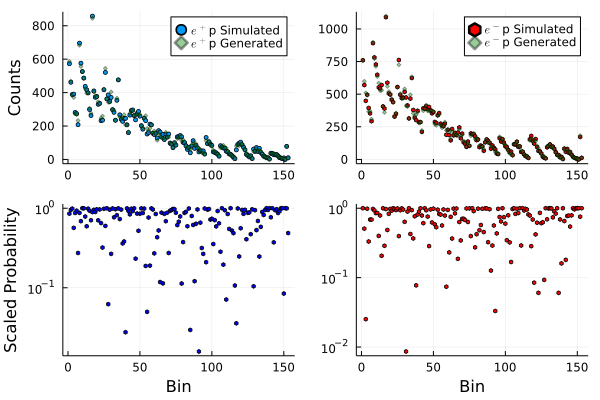

In [10]:
p1=scatter(counts_obs_ep_sim,  markersize=3, markershape=:circle,label=L"$e^+$p Simulated",ylab="Counts")
p1=scatter!(counts_pred_ep_gen, 
   markershape = :diamond,     markeralpha = 0.4,     markercolor = :green,  markersize = 2,
#    st=:sticks,
    label=L"$e^+$p Generated")
p2=scatter(counts_obs_em_sim,color="red", markersize=2,markershape=:hexagon,label=L"$e^-$p Simulated")
p2=scatter!(counts_pred_em_gen,color="red",    
    markershape = :diamond,     markeralpha = 0.4,     markercolor = :green,  markersize = 2,
    label=L"$e^-$p Generated",
    linewidth = 2)
p3=scatter(prob_ep_gen,color="blue",yscale=:log10,markersize=2,markershape=:hexagon,label="",xlab="Bin",ylab="Scaled Probability")
p4=scatter(prob_em_gen,color="red",yscale=:log10, markersize=2,markershape=:hexagon,label="",xlab="Bin")
plot(p1,p2,p3,p4,layout=(2,2))

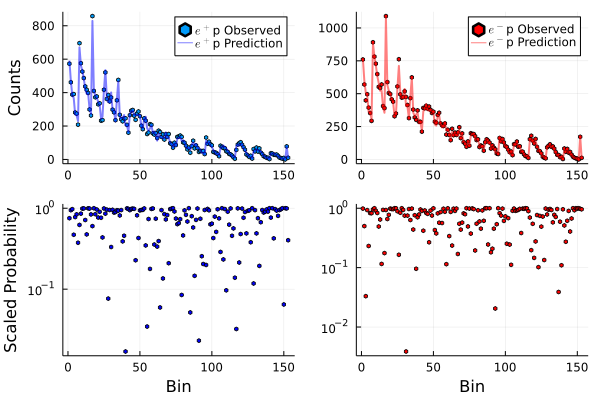

In [11]:
p1=scatter(counts_obs_ep_sim,  markersize=2, markershape=:hexagon,label=L"$e^+$p Observed",ylab="Counts")
p1=plot!(counts_pred_ep_sim,color="blue",    linealpha = 0.5,
    linewidth = 2,label=L"$e^+$p Prediction")
p2=scatter(counts_obs_em_sim,color="red", markersize=2,markershape=:hexagon,label=L"$e^-$p Observed")
p2=plot!(counts_pred_em_sim,color="red",    linealpha = 0.5,label=L"$e^-$p Prediction",
    linewidth = 2)
p3=scatter(prob_ep_sim,color="blue",yscale=:log10,markersize=2,markershape=:hexagon,label="",xlab="Bin",ylab="Scaled Probability")
p4=scatter(prob_em_sim,color="red",yscale=:log10, markersize=2,markershape=:hexagon,label="",xlab="Bin")
plot(p1,p2,p3,p4,layout=(2,2))

In [12]:
plot(p1,p2,p3,p4,layout=(2,2))
savefig("Simulation-GoF.pdf")

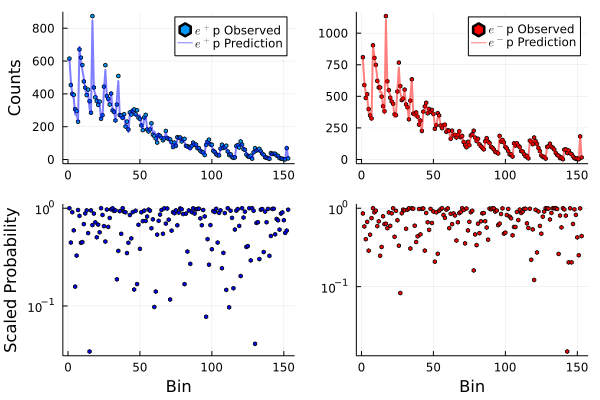

In [13]:
p1=scatter(counts_obs_ep_data,  markersize=2, markershape=:hexagon,label=L"$e^+$p Observed",ylab="Counts")
p1=plot!(counts_pred_ep_data,color="blue",    linealpha = 0.5,
    linewidth = 2,label=L"$e^+$p Prediction")
p2=scatter(counts_obs_em_data,color="red", markersize=2,markershape=:hexagon,label=L"$e^-$p Observed")
p2=plot!(counts_pred_em_data,color="red",    linealpha = 0.5,label=L"$e^-$p Prediction",
    linewidth = 2)
p3=scatter(prob_ep_data,color="blue",yscale=:log10,markersize=2,markershape=:hexagon,label="",xlab="Bin",ylab="Scaled Probability")
p4=scatter(prob_em_data,color="red",yscale=:log10, markersize=2,markershape=:hexagon,label="",xlab="Bin")
plot(p1,p2,p3,p4,layout=(2,2))

In [14]:
plot(p1,p2,p3,p4,layout=(2,2))
savefig("Data-GoF.pdf")

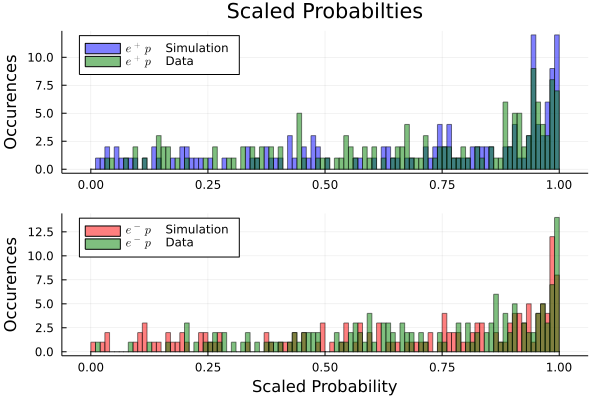

In [15]:
h1=histogram(prob_ep_sim,bins=0:0.01:1,label=L"$e^+p$    Simulation",legend=:topleft,alpha=0.5,color="blue",title="Scaled Probabilties")
h1=histogram!(prob_ep_data,bins=0:0.01:1,alpha=0.5,color="green",label=L"$e^+p$    Data",ylab="Occurences")

h2=histogram(prob_em_sim,bins=0:0.01:1,label=L"$e^-p$    Simulation",legend=:topleft,alpha=0.5,color="red",
    ylab="Occurences")
h2=histogram!(prob_em_data,bins=0:0.01:1,alpha=0.5,color="green",label=L"$e^-p$    Data", xlab="Scaled Probability")


plot(h1,h2,layout=(2,1))

In [16]:
savefig("Scaled-Poisson-prob.pdf")

In [17]:
testdist=zeros(2,101)
bin_gen=0
bin_sim=0
for i=1:nbins
    bin_gen=Int(floor(prob_ep_gen[i]*100+1))
    testdist[1,bin_gen]+=1
#    println(prob_ep_gen[i]," ",bin_gen)
    bin_sim=Int(floor(prob_ep_sim[i]*100+1))
    testdist[2,bin_sim]+=1
end
println(testdist[1,:])
println(testdist[2,:])

KSampleADTest(testdist[1,:],testdist[2,:])



[0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 3.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, 2.0, 3.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 3.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 4.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 3.0, 1.0, 0.0, 2.0, 0.0, 0.0, 3.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 4.0, 3.0, 1.0, 8.0, 1.0, 4.0, 0.0, 2.0, 4.0, 1.0, 6.0, 6.0, 7.0, 3.0, 6.0, 13.0, 8.0]
[0.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 3.0, 1.0, 0.0, 2.0, 1.0, 3.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 2.0, 4.0, 2.0, 4.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 2.0, 2.0, 4.0, 1.0, 1.0, 3.0, 12.0, 4.0, 3.0, 6.0, 9

k-sample Anderson-Darling test
------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: fail to reject h_0
    one-sided p-value:           0.9808

Details:
    number of samples:        2
    number of observations:   202
    SD of A²k:                0.7542638710024309
    A²k statistic:            0.23405937084798448
    standardized statistic:   -1.015480998889773
    modified test:            true
    p-value calculation:      asymptotic


In [18]:
testdist=zeros(2,101)
bin_sim=0
bin_data=0
for i=1:nbins
    bin_data=Int(floor(prob_ep_data[i]*100+1))
    testdist[1,bin_data]+=1
#    println(prob_ep_gen[i]," ",bin_gen)
    bin_sim=Int(floor(prob_ep_sim[i]*100+1))
    testdist[2,bin_sim]+=1
end
println(testdist[1,:])
println(testdist[2,:])

KSampleADTest(testdist[1,:],testdist[2,:])

[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 3.0, 2.0, 2.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 2.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 5.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 3.0, 2.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 4.0, 1.0, 1.0, 1.0, 3.0, 0.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 6.0, 2.0, 5.0, 5.0, 2.0, 3.0, 9.0, 6.0, 4.0, 3.0, 8.0, 7.0, 5.0]
[0.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 3.0, 1.0, 0.0, 2.0, 1.0, 3.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 2.0, 4.0, 2.0, 4.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 2.0, 2.0, 4.0, 1.0, 1.0, 3.0, 12.0, 4.0, 3.0, 6.0, 9.

k-sample Anderson-Darling test
------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: fail to reject h_0
    one-sided p-value:           0.9852

Details:
    number of samples:        2
    number of observations:   202
    SD of A²k:                0.7542638710024309
    A²k statistic:            0.22231683623569404
    standardized statistic:   -1.0310492039486798
    modified test:            true
    p-value calculation:      asymptotic


In [19]:
testdist=zeros(2,101)
bin_gen=0
bin_data=0
for i=1:nbins
    bin_data=Int(floor(prob_ep_data[i]*100+1))
    testdist[1,bin_data]+=1
#    println(prob_ep_gen[i]," ",bin_gen)
    bin_gen=Int(floor(prob_ep_gen[i]*100+1))
    testdist[2,bin_gen]+=1
end
println(testdist[1,:])
println(testdist[2,:])

KSampleADTest(testdist[1,:],testdist[2,:])

[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 3.0, 2.0, 2.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 2.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 5.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 3.0, 2.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 4.0, 1.0, 1.0, 1.0, 3.0, 0.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 6.0, 2.0, 5.0, 5.0, 2.0, 3.0, 9.0, 6.0, 4.0, 3.0, 8.0, 7.0, 5.0]
[0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 3.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, 2.0, 3.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 3.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 4.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 3.0, 1.0, 0.0, 2.0, 0.0, 0.0, 3.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 4.0, 3.0, 1.0, 8.0, 1.0, 4.0, 0.0, 2.0, 4.0, 1.0, 6.0, 6.0, 7.0, 3.0, 6.0

k-sample Anderson-Darling test
------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: fail to reject h_0
    one-sided p-value:           0.9868

Details:
    number of samples:        2
    number of observations:   202
    SD of A²k:                0.7542638710024309
    A²k statistic:            0.21771922943950509
    standardized statistic:   -1.0371446925077148
    modified test:            true
    p-value calculation:      asymptotic


In [20]:
testdist=zeros(2,101)
bin_gen=0
bin_data=0
for i=1:nbins
    bin_data=Int(floor(prob_em_data[i]*100+1))
    testdist[1,bin_data]+=1
#    println(prob_ep_gen[i]," ",bin_gen)
    bin_gen=Int(floor(prob_em_gen[i]*100+1))
    testdist[2,bin_gen]+=1
end
println(testdist[1,:])
println(testdist[2,:])

KSampleADTest(testdist[1,:],testdist[2,:])

[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 3.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 2.0, 3.0, 2.0, 1.0, 4.0, 1.0, 0.0, 3.0, 3.0, 2.0, 0.0, 3.0, 2.0, 2.0, 0.0, 2.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 3.0, 0.0, 3.0, 1.0, 2.0, 0.0, 2.0, 3.0, 6.0, 1.0, 4.0, 2.0, 5.0, 0.0, 3.0, 2.0, 2.0, 4.0, 5.0, 3.0, 7.0, 14.0, 7.0]
[1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 4.0, 1.0, 0.0, 0.0, 2.0, 1.0, 2.0, 0.0, 2.0, 0.0, 0.0, 3.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 3.0, 1.0, 1.0, 0.0, 1.0, 4.0, 1.0, 2.0, 0.0, 0.0, 1.0, 2.0, 3.0, 1.0, 1.0, 6.0, 1.0, 1.0, 2.0, 3.0, 1.0, 1.0, 4.0, 0.0, 0.0, 0.0, 3.0, 1.0, 0.0, 2.0, 5.0, 1.0, 5.0, 2.0, 6.0, 7.

k-sample Anderson-Darling test
------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: fail to reject h_0
    one-sided p-value:           0.8906

Details:
    number of samples:        2
    number of observations:   202
    SD of A²k:                0.7542638710024309
    A²k statistic:            0.36103800122231827
    standardized statistic:   -0.8471332425461255
    modified test:            true
    p-value calculation:      asymptotic
